# Ternary routing between experts
- The model resembles mixture of experts.
- Define expert networks that are small networks and they need to interact with networks up the hierarchy.
- The interaction is mediated by a routing matrix.

## Preliminary Experiment Design

### Design a ternary differentiable rule
- Using Trident framework, to be able to backprop through the ternary matrix of connectivity.

### Build a MoE model
- Experets of certain size talking across hierarchy.

### Test out with synthetic data
- Define random test inputs and labels.
- Assign them different penalty weights.

### Potential questions to ask
- Does the number of routing connections go up when the surprising/critical inputs are presented?
- What happens to the balance condition?


In [34]:
import jax
import jax.numpy as jnp
import flax
from flax import nnx
from flax.nnx.nn import initializers
import math
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from collections import defaultdict

# Define the trident-ternary activation

In [3]:
def ternary_activation(x, thresholds, noise_sd, key):
    """
    Ternary activation function
    """
    # key, key2 = jax.random.split(key, 2)

    # generate noise
    noise = jax.random.normal(key = key, shape = x.shape) * noise_sd

    # inject noise
    x = x + noise


    # threshold
    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s

# helper function
@jax.jit
def gaussian_cdf(x, mu, sigma):
    return jax.scipy.stats.norm.cdf(x, loc = mu, scale = sigma)

@jax.jit
def gaussian_pdf(x, mu, sigma):
    return jax.scipy.stats.norm.pdf(x, loc = mu, scale = sigma)

@jax.jit
def expected_state(x, thresholds, noise_sd):
    t1, t2 = thresholds
    e = ((1 - gaussian_cdf(x = t2 - x, mu = 0, sigma = noise_sd)) - gaussian_cdf(x = t1 - x, mu = 0, sigma = noise_sd))
    return e

# custom gradients

@jax.custom_vjp
def trident(x, thresholds, noise_sd, key):
    return ternary_activation(x = x, thresholds = thresholds, noise_sd = noise_sd, key = key) # call the ternary activation in the forward pass

def trident_fwd(x, thresholds, noise_sd, key):
    return trident(x, thresholds, noise_sd, key), (x, thresholds, noise_sd) # save the inputs, thresholds, noise_sd for the backward pass

def trident_bwd(residuals, grads):
    x, thresholds, noise_sd = residuals # unpack the residuals from forward pass
    t1, t2 = thresholds
    exp_state_grad = gaussian_pdf(x = t1 - x, mu = 0, sigma = noise_sd) + gaussian_pdf(x = t2 - x, mu = 0, sigma = noise_sd)
    return (exp_state_grad*grads, None, None, None)

trident.defvjp(trident_fwd, trident_bwd)



Text(0, 0.5, 'Custom Gradient')

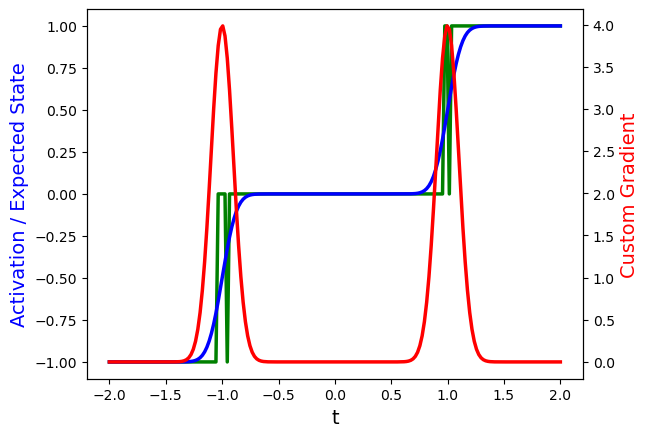

In [4]:
## testing
kk = jax.random.key(0)
t = jnp.linspace(-2, 2, 200)
th = [-1.0, 1.0]
noise_sd = 0.1
act = ternary_activation(t, th, 0.1, kk)
exp_st = expected_state(t, th, noise_sd)
cus_grad = jax.vmap(jax.grad(trident), in_axes=(0, None, None, None))(t, th, noise_sd, kk)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t, act, 'g-', lw = 2.5)
ax1.plot(t, exp_st, 'b-', lw = 2.5)
ax2.plot(t, cus_grad, 'r-', lw = 2.5)

ax1.set_xlabel('t', fontsize = 14)
ax1.set_ylabel('Activation / Expected State', color='b', fontsize = 14)
ax2.set_ylabel('Custom Gradient', color='r', fontsize = 14)

In [5]:
## testing 2
key = jax.random.key(4562)
x_test = jax.random.normal(key, (10, 100))
th_test = [-0.5, 0.5]
noise_sd_test = 0.1
# outs = jax.vmap(trident, in_axes=(0, None, None, None))(x_test, th_test, noise_sd_test, key)
outs = trident(x_test, th_test, noise_sd_test, key)
print(outs.shape, "\n", outs)

(10, 100) 
 [[ 0. -1. -1.  0. -1. -1.  0. -1.  1.  0.  0. -1.  0.  1. -1. -1. -1. -1.
   1.  1. -1.  1.  1. -1. -1.  1. -1.  0.  1.  0. -1. -1.  0. -1.  1.  0.
   0.  0. -1.  1. -1.  0. -1.  1. -1. -1.  0. -1. -1. -1.  0. -1.  0. -1.
  -1.  1.  1. -1. -1.  1.  0.  0. -1.  1.  1.  0. -1.  0. -1.  1.  1. -1.
   1. -1. -1.  0.  0. -1.  0. -1.  0.  1. -1.  1.  1. -1.  1. -1. -1.  1.
  -1.  1.  0.  1. -1.  0.  0.  0. -1. -1.]
 [-1.  1. -1. -1.  0. -1.  0.  0. -1.  0.  0.  1.  0.  1. -1.  1. -1.  0.
   1.  1.  0.  0.  0. -1. -1. -1.  1. -1.  0.  0. -1.  1. -1.  0.  0.  1.
  -1. -1.  1. -1.  0.  0. -1.  1.  0.  0. -1.  1. -1.  1. -1. -1.  1. -1.
   1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0. -1. -1. -1.  0. -1.  0.
   1.  0.  1.  1.  1.  1. -1.  1.  0.  1.  1. -1.  1.  0.  1. -1.  0. -1.
   1.  1.  0. -1.  1. -1. -1. -1.  1.  0.]
 [-1.  1.  0.  1.  0.  0. -1. -1.  0.  1. -1.  0.  0. -1.  0. -1. -1.  1.
  -1.  0.  1. -1. -1. -1.  0.  1.  0.  0. -1. -1. -1. -1. -1.  0.  1. -1.
   1.  0.  0. 

## Define a toy MoE model
- Each expert is parametrized by a $n\times m$ matrix. For ease we can start with $n = m = 10$
- Define routing matrices between the hierarchical level. Every element of this matrix $\mathbf{C}_{ij} ~ \forall ~ i,j  \in \{-1, 0, +1\}$.
- Apply any activation to the experts.
- Apply trident to the routing matrices

In [37]:
class TridentMOELayer(nnx.Module):

    def __init__(self, 
                 in_features: int, # input feature dimension
                 num_experts: int, # number of smaller experts
                 expert_size: int, # size of each expert
                 rngs: nnx.Rngs,
                 thresholds: list = [-0.5, 0.5], # thresholds for ternary activation
                 noise_sd: float = 0.1, # standard deviation of the noise injected before ternary activation
                 ):
        
        self.in_features = in_features
        self.num_experts = num_experts
        self.expert_size = expert_size
        self.rngs = rngs
        self.thresholds = thresholds
        self.noise_sd = noise_sd
        
        # compute the size of the routing matrix
        in_chunks = math.ceil(in_features/expert_size) # find the number of chuks of in the input that the experts will handle

        glorot_init = initializers.glorot_normal()
        self.routing_matrix = nnx.Param(
            glorot_init(rngs.params(), (in_chunks, num_experts))
        )

        # define the weights of the experts
        self.We = nnx.Param(
            glorot_init(rngs.params(), (num_experts, expert_size, expert_size))
        )

    def __call__(self, x: jnp.array) -> jnp.array:
        """
        Forward pass through the layer
        Args:
        x: input array of shape (samples/batch size, in_features)
        """

        # reshape x into chunks of expert size
        x = x.reshape(x.shape[0], -1, self.expert_size)

        # print(x.shape)
        # print(self.routing_matrix.shape)

        # make sure that the the routing matrix is ternary
        ternary_routing = trident(self.routing_matrix.value, self.thresholds, self.noise_sd, self.rngs.dropout())

        # route the inputs to the experts
        x_routed = jnp.einsum('ik, bij -> bkj', ternary_routing, x) # shape (batch size, num_experts, expert_size)

        # pass the routed inputs through experts
        x_experts = jnp.einsum('eij, bej -> bei', self.We.value, x_routed) # shape (batch size, num_experts, expert_size)

        # combine the outputs of the experts
        y = x_experts.reshape(x.shape[0], -1) # shape (batch size, num_experts * expert_size)

        return y





In [38]:
## testing the layer
key = jax.random.key(4562)
rngs = nnx.Rngs(params=0, dropout=1)
x_test = jax.random.normal(rngs.params(), (10, 100))
print(f"x_test shape: {x_test.shape}")

test_layer = TridentMOELayer(
    in_features=x_test.shape[1],
    num_experts=20,
    expert_size=10,
    rngs=rngs,
    thresholds=[-0.5, 0.5],
    noise_sd=0.1
)

nnx.display(test_layer)
outs = test_layer(x_test)
print(f"outs.shape: {outs.shape}")
print(f"outs[0, :20]: {outs[0, :20]}")

x_test shape: (10, 100)


outs.shape: (10, 200)
outs[0, :20]: [-0.63138264 -0.22775787 -0.2960862  -0.12129119  0.18302613 -0.15263242
  0.6094241   0.27472413  0.30847254  0.258298    0.42390597  0.01733564
  0.47580272 -0.6577079   0.2255581  -0.07263911  0.27643365 -0.13463777
  0.21428925 -0.18741386]


In [39]:
## build a network with one hidden layer of experts
class TridentMOENet(nnx.Module):

    def __init__(self, 
                 in_features: int, 
                 num_experts: int, 
                 expert_size: int, 
                 rngs: nnx.Rngs,
                 thresholds: list = [-0.5, 0.5], 
                 noise_sd: float = 0.1, 
                 layer_sizes: list = [30, 10], # in terms of number of experts
                 ):
        self.in_features = in_features
        self.num_experts = num_experts
        self.expert_size = expert_size
        self.rngs = rngs
        self.thresholds = thresholds
        self.noise_sd = noise_sd
        self.in_chunks = math.ceil(in_features/expert_size)

        layer_sizes.insert(0, self.in_chunks)
        self.layer_sizes = layer_sizes

        self.layers = [
            TridentMOELayer(
                in_features=li*self.expert_size,
                num_experts=lo,
                expert_size=self.expert_size,
                rngs=self.rngs,
                thresholds=self.thresholds,
                noise_sd=self.noise_sd
            )

            for li, lo in zip(self.layer_sizes[:-1], self.layer_sizes[1:])
        ]

    def __call__(self, x: jnp.array) -> jnp.array:
        for layer in self.layers:
            x = layer(x)
        return x



In [40]:
## testing the network
key = jax.random.key(462)
rngs = nnx.Rngs(params=0, dropout=1)
x_test = jax.random.normal(rngs.params(), (10, 100))
print(f"x_test shape: {x_test.shape}")

test_net = TridentMOENet(
    in_features=x_test.shape[1],
    num_experts=20,
    expert_size=10,
    rngs=rngs,
    thresholds=[-0.5, 0.5],
    noise_sd=0.1,
    layer_sizes=[30, 10]
)
nnx.display(test_net)

outs = test_net(x_test)
print(f"outs.shape: {outs.shape}")


x_test shape: (10, 100)


outs.shape: (10, 100)


In [ ]:
## Now define test inputs and labels...